### Take in the fits file and create a pupil to feed into FT_model code

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math
from math import tan, atan, hypot
from FT_model import model_FT
from fits_to_pupil import generate_pupil
from mpl_toolkits.axes_grid1 import make_axes_locatable
from radial_gradient import RWGE
from power_region import power_ratio
from symmetry import create_symmetry

In [2]:
%%time
indexes = [10, 3, 4, 8, 9]
pupils = []

for i in indexes:
    pupil_name = "ToliBoy_Pupil_Designs/ToliBoy_Pupil_{}.fits".format(i)
    pupil = generate_pupil(fits.open(pupil_name)[0].data)
        
    if i == 4:
        pupil = create_symmetry(pupil, 10)

    pupils.append(pupil)

/Users/louis/Pupil_design/Pupil_simulations/symmetry.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  B[i][j] += A[k][l]/f


CPU times: user 28.8 s, sys: 147 ms, total: 29 s
Wall time: 29.3 s


In [8]:
aperture = 0.018                 # Aperture (m)
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-6                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)
lam = 525e-9

# Modify these values to change analysis
num_fringes = 10.5
fringe_extent_im = 15
fringe_extent_graph = 15

c = npixels//2
pixel_radii = fl*tan(num_fringes*lam/aperture)/detector_pitch
pixel_extent_im = int(fl*tan(2*fringe_extent_im*lam/aperture)/detector_pitch)
pixel_extent_graph = int(fl*tan(2*fringe_extent_graph*lam/aperture)/detector_pitch)
xvals = np.linspace(0, fringe_extent_im, pixel_extent_im//2)

In [9]:
%%time
outputs = []
for pupil in pupils:
    
    im_out = model_FT(pupil, aperture, npixels, [wl], fl, detector_pitch)
    im_out = im_out/np.sum(im_out)
        
    gradient = "{:.2f}".format(RWGE(im_out)*1e6)
    gradient_in = "{:.2f}".format(RWGE(im_out, max=pixel_radii)*1e6)
    ratio = "{:.2f}".format(power_ratio(im_out, pixel_radii)*100)
    pixel_peak = "{:.2f}".format(np.max(im_out)*1e5)
    central = "{:.2f}".format(im_out[im_out.shape[0]//2][im_out.shape[0]//2]*1e5)
    
    evaluation = [gradient, gradient_in, ratio, pixel_peak, central]

    regions = np.zeros(npixels)
    peaks = np.zeros(npixels)
    cum_sum = np.zeros(npixels)
    
    for j in range(npixels):
        for k in range(npixels):
            x = j - c
            y = k - c
            r = int(hypot(x, y))
            regions[r] += im_out[j][k]
            peaks[r] = im_out[j][k] if im_out[j][k] > peaks[r] else peaks[r]
    
    for j in range(len(regions)):
        cum_sum[j] = regions[j] if j == 0 else cum_sum[j-1] + regions[j]
            
    outputs.append([pupil, im_out, evaluation, regions, peaks, cum_sum])

CPU times: user 34.6 s, sys: 1.58 s, total: 36.2 s
Wall time: 30.8 s


    _____________________________________________________________________
    | MAXIMISE:				| MINIMISE: 			|
    _____________________________________________________________________
    | RWGE over array:		37.00   | Peak pixel value:	65.99 	|
    | RWGE inside 10.5 λ/D:	36.33   | Central pixel value:	4.61 	|
    | % Power in 10.5 λ/D:	76.38   |				|
    _____________________________________________________________________



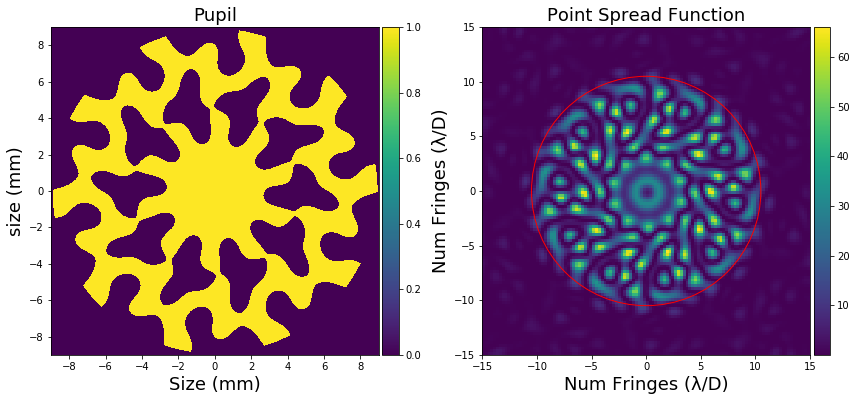

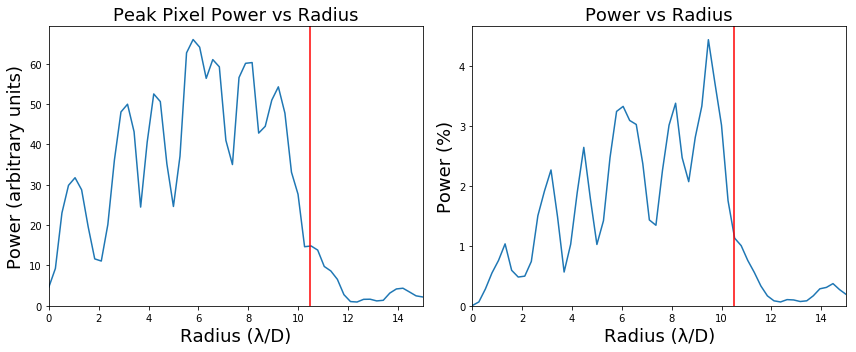

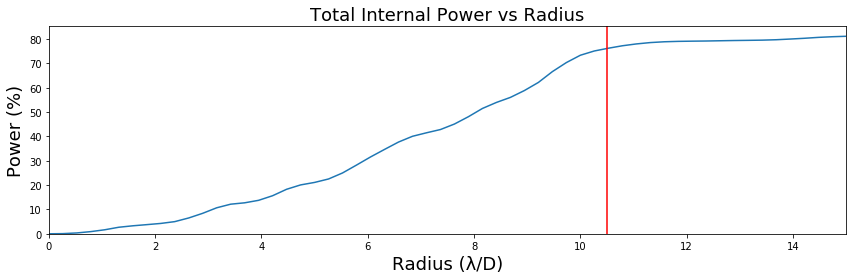

______________________________________________________________________________________________________________




    _____________________________________________________________________
    | MAXIMISE:				| MINIMISE: 			|
    _____________________________________________________________________
    | RWGE over array:		43.26   | Peak pixel value:	86.19 	|
    | RWGE inside 10.5 λ/D:	42.18   | Central pixel value:	66.82 	|
    | % Power in 10.5 λ/D:	68.81   |				|
    _____________________________________________________________________



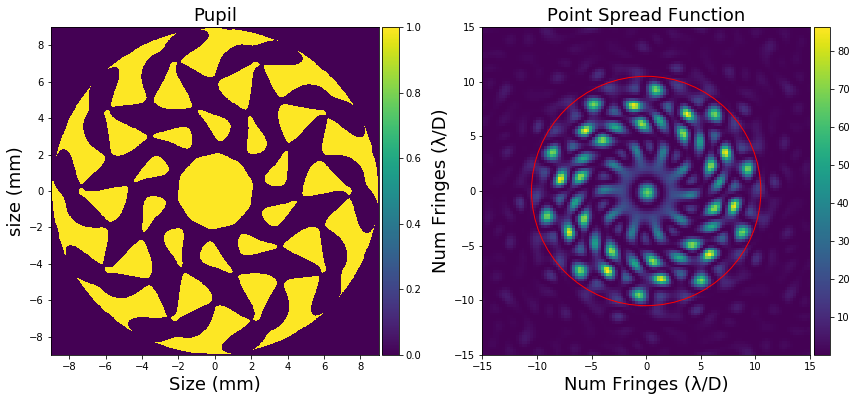

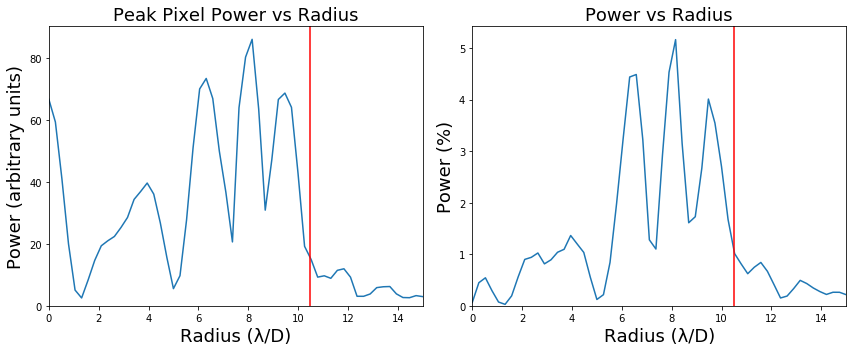

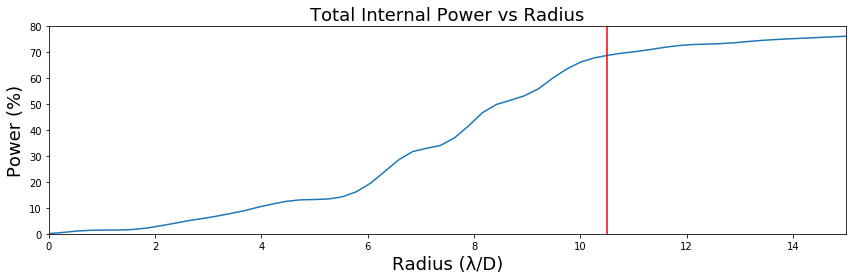

______________________________________________________________________________________________________________




    _____________________________________________________________________
    | MAXIMISE:				| MINIMISE: 			|
    _____________________________________________________________________
    | RWGE over array:		47.47   | Peak pixel value:	75.06 	|
    | RWGE inside 10.5 λ/D:	46.98   | Central pixel value:	26.09 	|
    | % Power in 10.5 λ/D:	80.11   |				|
    _____________________________________________________________________



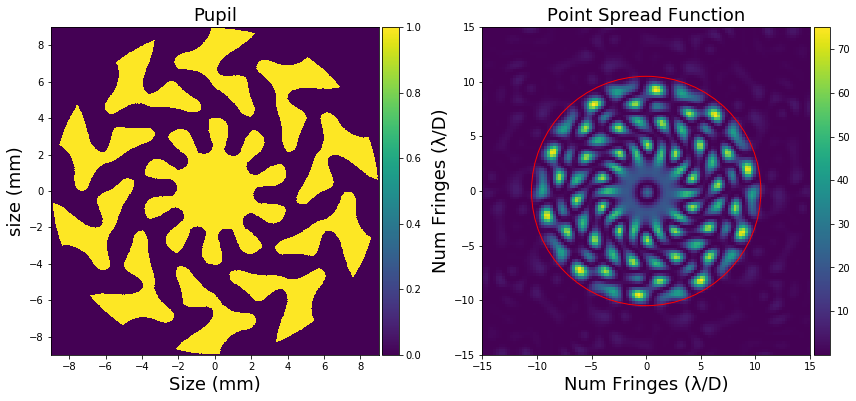

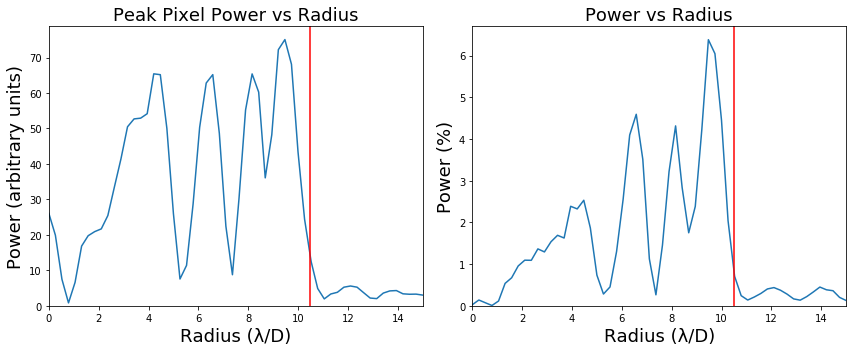

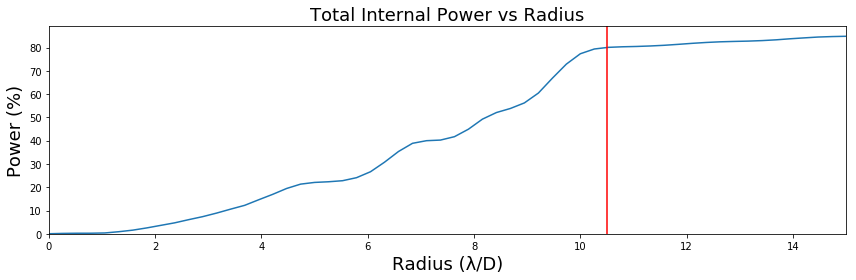

______________________________________________________________________________________________________________




    _____________________________________________________________________
    | MAXIMISE:				| MINIMISE: 			|
    _____________________________________________________________________
    | RWGE over array:		19.46   | Peak pixel value:	43.37 	|
    | RWGE inside 10.5 λ/D:	13.25   | Central pixel value:	7.32 	|
    | % Power in 10.5 λ/D:	49.97   |				|
    _____________________________________________________________________



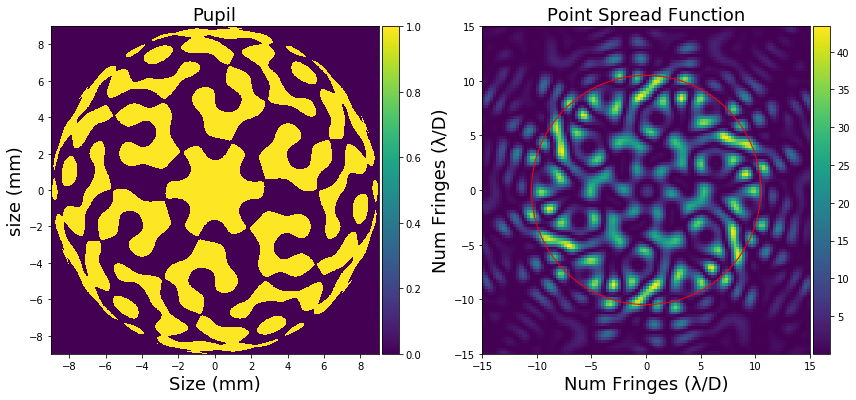

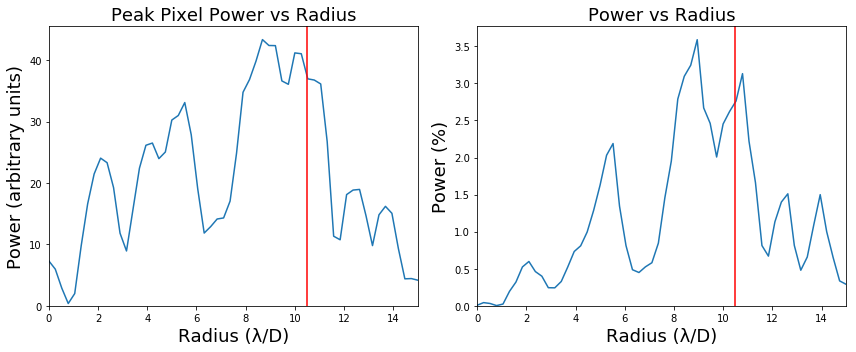

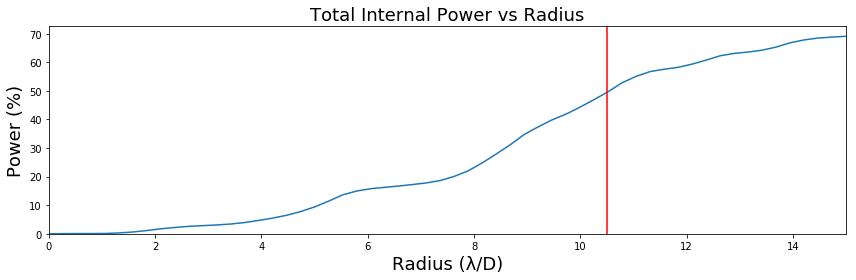

______________________________________________________________________________________________________________




    _____________________________________________________________________
    | MAXIMISE:				| MINIMISE: 			|
    _____________________________________________________________________
    | RWGE over array:		22.43   | Peak pixel value:	35.56 	|
    | RWGE inside 10.5 λ/D:	16.68   | Central pixel value:	13.78 	|
    | % Power in 10.5 λ/D:	53.49   |				|
    _____________________________________________________________________



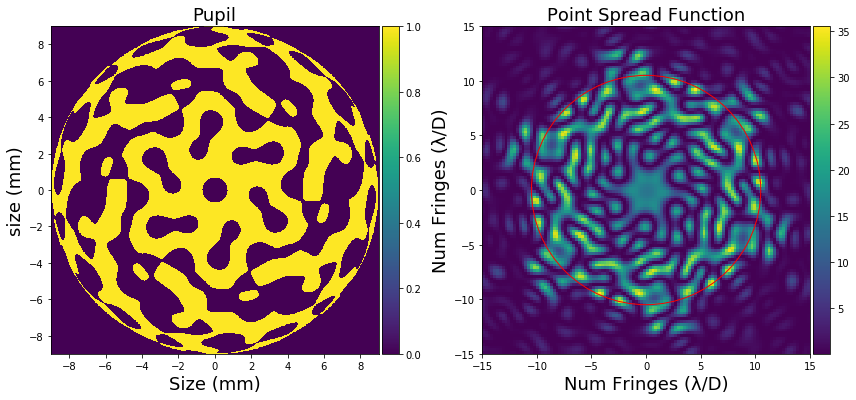

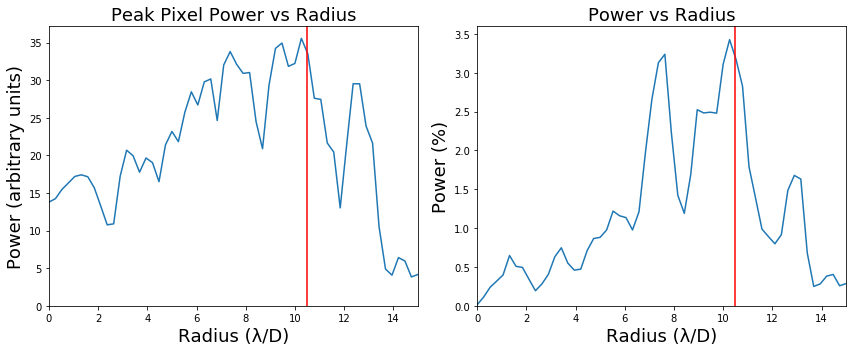

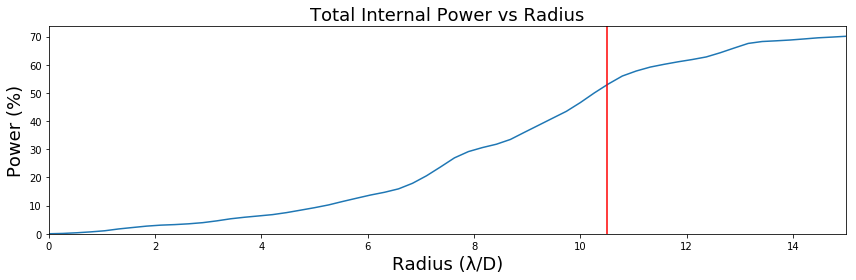

______________________________________________________________________________________________________________






In [12]:
for pupil_file in outputs:
    pupil = pupil_file[0]
    im_out = pupil_file[1]
    evaluation = pupil_file[2]
    regions = pupil_file[3]
    peaks = pupil_file[4]
    cum_sum = pupil_file[5]

    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    extent = -aperture*1e3/2, aperture*1e3/2, -aperture*1e3/2, aperture*1e3/2
    im = axs[0].imshow(np.abs(np.angle(pupil)/np.pi), extent=extent)
    plt.colorbar(im, cax=make_axes_locatable(axs[0]).append_axes("right", size="5%", pad=0.05))
    axs[0].set_title("Pupil", fontsize=18)
    axs[0].set_xlabel("Size (mm)", fontsize=18)
    axs[0].set_ylabel("size (mm)", fontsize=18) 
    
    print("    _____________________________________________________________________\n\
    | MAXIMISE:\t\t\t\t| MINIMISE: \t\t\t|\n\
    _____________________________________________________________________\n\
    | RWGE over array:\t\t{1}   | Peak pixel value:\t{4} \t|\n\
    | RWGE inside {0} \u03BB/D:\t{2}   | Central pixel value:\t{5} \t|\n\
    | % Power in {0} \u03BB/D:\t{3}   |\t\t\t\t|\n\
    _____________________________________________________________________\n"
    .format(num_fringes, evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
    
    extent = -fringe_extent_im, fringe_extent_im, -fringe_extent_im, fringe_extent_im
    im = axs[1].imshow(im_out[int(c-pixel_extent_im//2):int(c+pixel_extent_im//2),\
                              int(c-pixel_extent_im//2):int(c+pixel_extent_im//2)]*1e5, extent=extent)
    axs[1].set_title("Point Spread Function", fontsize=18)
    axs[1].set_xlabel("Num Fringes (\u03BB/D)", fontsize=18)
    axs[1].set_ylabel("Num Fringes (\u03BB/D)", fontsize=18) 
    axs[1].add_artist(plt.Circle((0, 0), num_fringes, color='r', fill=False))

    plt.colorbar(im, cax=make_axes_locatable(axs[1]).append_axes("right", size="5%", pad=0.05))
    plt.tight_layout()
    plt.show() 

    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    im = axs[0].plot(xvals[:pixel_extent_graph//2],peaks[:pixel_extent_graph//2]*1e5)
    axs[0].set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs[0].set_ylim(ymin=0)
    axs[0].set_title("Peak Pixel Power vs Radius", fontsize=18)
    axs[0].set_xlabel("Radius (\u03BB/D)", fontsize=18)
    axs[0].set_ylabel("Power (arbitrary units)", fontsize=18)
    axs[0].axvline(x=num_fringes, color='r')

    im = axs[1].plot(xvals[:pixel_extent_graph//2],regions[:pixel_extent_graph//2]*100)
    axs[1].set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs[1].set_ylim(ymin=0)
    axs[1].set_title("Power vs Radius", fontsize=18)
    axs[1].set_xlabel("Radius (\u03BB/D)", fontsize=18)
    axs[1].set_ylabel("Power (%)", fontsize=18) 
    axs[1].axvline(x=num_fringes, color='r')

    plt.tight_layout()
    plt.show()
    
    fig, axs = plt.subplots(1, 1, figsize=(12,4))
    im = axs.plot(xvals[:pixel_extent_graph//2],cum_sum[:pixel_extent_graph//2]*100)
    axs.set_xlim(xmin=0, xmax=fringe_extent_graph)
    axs.set_ylim(ymin=0)
    axs.set_title("Total Internal Power vs Radius", fontsize=18)
    axs.set_xlabel("Radius (\u03BB/D)", fontsize=18)
    axs.set_ylabel("Power (%)", fontsize=18)
    axs.axvline(x=num_fringes, color='r')
    
    plt.tight_layout()
    plt.show()
    print("______________________________________________________________________________________________________________\n\n\n\n")